In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

# Neural Networks

In [ ]:
# SigmaNet
class SigmaNet(nn.Module):
    def __init__(self, hidden_size=32):
        super(SigmaNet, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        
    def forward(self, s, S_s):
        x = torch.cat((s, S_s), dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        sigma_s = self.fc3(x)
        sigma_s = self.softplus(sigma_s)  # Ensure sigma_s > 0
        return sigma_s

# UFunctionNet
class UFunctionNet(nn.Module):
    def __init__(self, hidden_size=32):
        super(UFunctionNet, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()  # Use ReLU activation

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        u = self.relu(self.fc4(x))
        return u

# Distribution Function

In [ ]:
# Sampling functions remain the same
def mu1(size):
    return np.random.uniform(low=-1.0, high=1.0, size=size)

def mu2(size):
    u = np.random.uniform(low=0.0, high=1.0, size=size)
    uniform_neg1_to_1 = np.random.uniform(low=-1.0, high=1.0, size=size)
    uniform_0_to_1 = np.random.uniform(low=0.0, high=1.0, size=size)

    case1 = -2.0 + np.sqrt(uniform_0_to_1)
    case2 = uniform_neg1_to_1
    case3 = 2.0 - np.sqrt(uniform_0_to_1)

    return np.where(u < 1.0/6.0, case1, np.where(u < 5.0/6.0, case2, case3))

# Simulate X2 (s2) and Compute Loss

In [ ]:
def simulate_S2_multiple(X, sigma_net, num_paths=10, num_steps=50):
    batch_size = X.size(0)
    dt = 1.0 / num_steps

    # Expand X to match the number of paths
    X_expanded = X.unsqueeze(1).repeat(1, num_paths)    # Shape: (batch_size, num_paths)
    S_s = X_expanded.clone()                            # Shape: (batch_size, num_paths)

    # Initialize W_s (cumulative Brownian motion) to zero at t = 1
    W_s = torch.zeros_like(S_s)                         # Shape: (batch_size, num_paths)

    for i in range(num_steps):
        s = torch.full((batch_size, num_paths), 1.0 + i * dt).float()  # Current time t

        # Flatten inputs for sigma_net
        s_flat = s.reshape(-1, 1)                       # Shape: (batch_size * num_paths, 1)
        W_s_flat = W_s.reshape(-1, 1)                   # Shape: (batch_size * num_paths, 1)

        # Compute sigma_s using (t, W_{t-1}) as inputs
        sigma_s = sigma_net(s_flat, W_s_flat)           # shape: (batch_size * num_paths, 1)
        sigma_s = sigma_s.reshape(batch_size, num_paths)

        # Brownian increments
        dB_s = torch.randn(batch_size, num_paths) * np.sqrt(dt)  # Shape: (batch_size, num_paths)

        # Update S_s
        S_s = S_s + sigma_s * dB_s                      # Shape: (batch_size, num_paths)

        # Update W_s with the current Brownian increment
        W_s = W_s + dB_s  # W_s at time t

    # Return the final states S_2
    S_2 = S_s                                           # Shape: (batch_size, num_paths)
    return S_2

# compute_loss function remains the same
def compute_loss(X, Y, sigma_net, u2_net, num_paths=10):
    # Simulate multiple paths for each X
    S_2 = simulate_S2_multiple(X, sigma_net, num_paths=num_paths)
    batch_size = X.size(0)

    # Expand X to match the shape of S_2
    X_expanded = X.unsqueeze(1).repeat(1, num_paths)

    # Compute cost C(X, S_2)
    cost = torch.abs(S_2 - X_expanded)

    # Compute u_2(S_2)
    u2_S2 = u2_net(S_2.reshape(-1, 1)).reshape(batch_size, num_paths)

    # Compute cost - u2_S2
    cost_minus_u2 = cost - u2_S2

    # Compute conditional expectations for each X
    conditional_expectations = cost_minus_u2.mean(dim=1)

    # Compute u2_Y
    u2_Y = u2_net(Y.unsqueeze(1)).squeeze()

    # Compute the overall loss
    loss = conditional_expectations.mean() + u2_Y.mean()
    return loss, conditional_expectations.mean(), u2_Y.mean(), cost.mean()

# $N_P$ = 5

In [ ]:
# Initialize neural networks
sigma_net = SigmaNet()
u2_net = UFunctionNet()


# Learning rates
learning_rate_sigma_initial = 1e-4
learning_rate_u2_initial = 1e-4
decay_rate = 0.80
steps = 1000


num_epochs = 15000
batch_size = 64
num_paths = 5  # Num of Simulated Paths = 5!
loss_arr = []
# Momentum parameters
beta = 0.90  # Momentum coefficient

# Initialize velocity variables for sigma_net and u2_net parameters
v_sigma = [torch.zeros_like(p) for p in sigma_net.parameters()]
v_u2 = [torch.zeros_like(p) for p in u2_net.parameters()]

# Training loop with Momentum in Stochastic Extragradient Method
for epoch in range(num_epochs):
    learning_rate_sigma = learning_rate_sigma_initial * decay_rate ** np.floor(epoch / steps)
    learning_rate_u2 = learning_rate_u2_initial * decay_rate ** np.floor(epoch / steps)
    
    # Sample X and Y
    X_np = mu1(batch_size)
    Y_np = mu2(batch_size)
    X = torch.from_numpy(X_np).float()
    Y = torch.from_numpy(Y_np).float()

    # Step 1: Compute gradients at current parameters (sigma_k, u_k)
    # Zero gradients
    for p in sigma_net.parameters():
        if p.grad is not None:
            p.grad.zero_()
    for p in u2_net.parameters():
        if p.grad is not None:
            p.grad.zero_()

    # Compute loss at current parameters
    loss_current, inner_mean_current, u2Y_mean_current, cost_mean_current = compute_loss(
        X, Y, sigma_net, u2_net, num_paths=num_paths
    )

    # Compute gradients
    loss_current.backward()

    # Save copies of the current parameters and gradients
    sigma_params_backup = [p.data.clone() for p in sigma_net.parameters()]
    u2_params_backup = [p.data.clone() for p in u2_net.parameters()]

    sigma_grads_current = [p.grad.data.clone() for p in sigma_net.parameters()]
    u2_grads_current = [p.grad.data.clone() for p in u2_net.parameters()]

    # Step 2: Extrapolation step to intermediate parameters (without momentum)
    with torch.no_grad():
        # Update parameters for sigma_net (minimization)
        for p, g in zip(sigma_net.parameters(), sigma_grads_current):
            p.add_(-learning_rate_sigma * g)  # p = p - learning_rate * g (no momentum)

        # Update parameters for u2_net (maximization)
        for p, g in zip(u2_net.parameters(), u2_grads_current):
            p.add_(learning_rate_u2 * g)  # p = p + learning_rate * g (no momentum)

    # Step 3: Compute gradients at intermediate parameters
    # Zero gradients
    for p in sigma_net.parameters():
        p.grad.zero_()
    for p in u2_net.parameters():
        p.grad.zero_()

    # Re-sample data for intermediate step (or use the same data)
    X_np_intermediate = mu1(batch_size)
    Y_np_intermediate = mu2(batch_size)
    X_intermediate = torch.from_numpy(X_np_intermediate).float()
    Y_intermediate = torch.from_numpy(Y_np_intermediate).float()

    # Compute loss at intermediate parameters
    loss_intermediate, inner_mean_intermediate, u2Y_mean_intermediate, cost_mean_intermediate = compute_loss(
        X_intermediate, Y_intermediate, sigma_net, u2_net, num_paths=num_paths
    )

    # Backward to compute gradients at intermediate parameters
    loss_intermediate.backward()

    # Store gradients at intermediate point
    sigma_grads_intermediate = [p.grad.data.clone() for p in sigma_net.parameters()]
    u2_grads_intermediate = [p.grad.data.clone() for p in u2_net.parameters()]

    # Step 4: Restore original parameters
    with torch.no_grad():
        for p, p_backup in zip(sigma_net.parameters(), sigma_params_backup):
            p.data.copy_(p_backup)
        for p, p_backup in zip(u2_net.parameters(), u2_params_backup):
            p.data.copy_(p_backup)

    # Step 5: Final update using gradients at intermediate point with momentum
    with torch.no_grad():
        # Update velocities and parameters for sigma_net (minimization)
        for p, g, v in zip(sigma_net.parameters(), sigma_grads_intermediate, v_sigma):
            v.mul_(beta).add_((1 - beta), -learning_rate_sigma * g)  # v = beta * v - learning_rate * g
            p.add_(v)  # p = p + v

        # Update velocities and parameters for u2_net (maximization)
        for p, g, v in zip(u2_net.parameters(), u2_grads_intermediate, v_u2):
            v.mul_(beta).add_((1 - beta), learning_rate_u2 * g)  # v = beta * v + learning_rate * g
            p.add_(v)  # p = p + v

    # Zero gradients for next iteration
    for p in sigma_net.parameters():
        p.grad.zero_()
    for p in u2_net.parameters():
        p.grad.zero_()

    loss_arr.append(loss_current.item())
    # Print loss and other metrics every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_current.item():.4f}, "
              f"Inner Mean: {inner_mean_current.item():.4f}, U2_Y Mean: {u2Y_mean_current.item():.4f}, "
              f"Cost Mean: {cost_mean_current.item():.4f}")

Epoch 0, Loss: 0.5518, Inner Mean: 0.4300, U2_Y Mean: 0.1218, Cost Mean: 0.5621
Epoch 500, Loss: 0.5829, Inner Mean: 0.4229, U2_Y Mean: 0.1601, Cost Mean: 0.5427
Epoch 1000, Loss: 0.5273, Inner Mean: 0.4059, U2_Y Mean: 0.1214, Cost Mean: 0.5058
Epoch 1500, Loss: 0.4538, Inner Mean: 0.3287, U2_Y Mean: 0.1252, Cost Mean: 0.4409
Epoch 2000, Loss: 0.4850, Inner Mean: 0.3661, U2_Y Mean: 0.1189, Cost Mean: 0.4886
Epoch 2500, Loss: 0.4806, Inner Mean: 0.3535, U2_Y Mean: 0.1271, Cost Mean: 0.4442
Epoch 3000, Loss: 0.4241, Inner Mean: 0.3052, U2_Y Mean: 0.1189, Cost Mean: 0.4074
Epoch 3500, Loss: 0.4113, Inner Mean: 0.3116, U2_Y Mean: 0.0997, Cost Mean: 0.4149
Epoch 4000, Loss: 0.4684, Inner Mean: 0.3294, U2_Y Mean: 0.1390, Cost Mean: 0.4106
Epoch 4500, Loss: 0.4326, Inner Mean: 0.3105, U2_Y Mean: 0.1221, Cost Mean: 0.3924
Epoch 5000, Loss: 0.3806, Inner Mean: 0.3042, U2_Y Mean: 0.0764, Cost Mean: 0.4025
Epoch 5500, Loss: 0.3797, Inner Mean: 0.2611, U2_Y Mean: 0.1186, Cost Mean: 0.3655
Epoch 60

0.0005913711175143297
0.34504898595809935


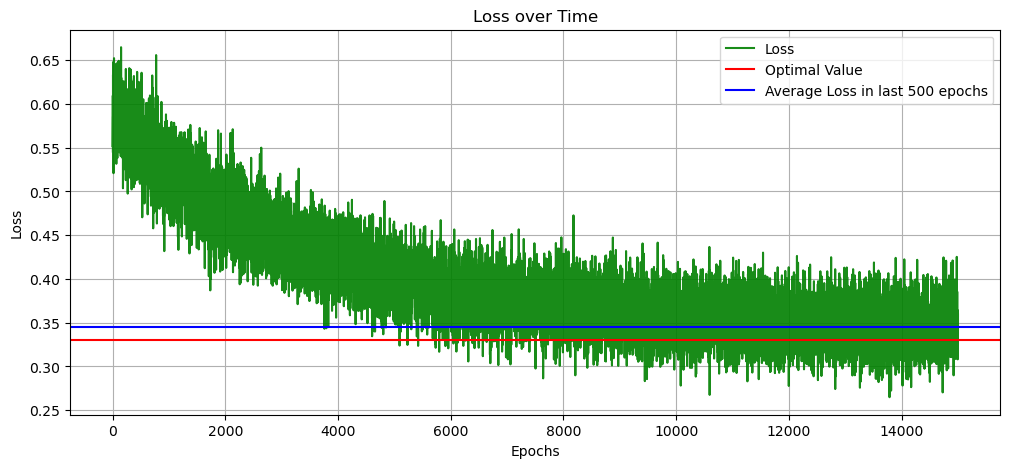

In [23]:
plt.figure(figsize=(12,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Time')

plt.grid()
plt.plot(np.arange(len(loss_arr)), loss_arr, alpha=0.9, color='green', label='Loss')
plt.axhline(0.33, color='red', label='Optimal Value')
plt.axhline(np.mean(loss_arr[-500:]), color='blue', label='Average Loss in last 500 epochs')
plt.legend()
print(np.var(loss_arr[-500:]))
print(np.mean(loss_arr[-500:]))


# $N_P = 2$

In [ ]:
# Initialize neural networks
sigma_net = SigmaNet()
u2_net = UFunctionNet()

# Learning rates
learning_rate_sigma_initial = 1e-4
learning_rate_u2_initial = 1e-4
decay_rate = 0.80
steps = 1000

num_epochs = 15000
batch_size = 64
num_paths = 2
loss_arr = []


beta = 0.90  # Momentum coefficient

# Initialize velocity variables for sigma_net and u2_net parameters
v_sigma = [torch.zeros_like(p) for p in sigma_net.parameters()]
v_u2 = [torch.zeros_like(p) for p in u2_net.parameters()]

# Training loop with Momentum in Stochastic Extragradient Method
for epoch in range(num_epochs):
    learning_rate_sigma = learning_rate_sigma_initial * decay_rate ** np.floor(epoch / steps)
    learning_rate_u2 = learning_rate_u2_initial * decay_rate ** np.floor(epoch / steps)
    
    # Sample X and Y
    X_np = mu1(batch_size)
    Y_np = mu2(batch_size)
    X = torch.from_numpy(X_np).float()
    Y = torch.from_numpy(Y_np).float()

    # Step 1: Compute gradients at current parameters (sigma_k, u_k)
    # Zero gradients
    for p in sigma_net.parameters():
        if p.grad is not None:
            p.grad.zero_()
    for p in u2_net.parameters():
        if p.grad is not None:
            p.grad.zero_()

    # Compute loss at current parameters
    loss_current, inner_mean_current, u2Y_mean_current, cost_mean_current = compute_loss(
        X, Y, sigma_net, u2_net, num_paths=num_paths
    )

    # Compute gradients
    loss_current.backward()

    # Save copies of the current parameters and gradients
    sigma_params_backup = [p.data.clone() for p in sigma_net.parameters()]
    u2_params_backup = [p.data.clone() for p in u2_net.parameters()]

    sigma_grads_current = [p.grad.data.clone() for p in sigma_net.parameters()]
    u2_grads_current = [p.grad.data.clone() for p in u2_net.parameters()]

    # Step 2: Extrapolation step to intermediate parameters (without momentum)
    with torch.no_grad():
        # Update parameters for sigma_net (minimization)
        for p, g in zip(sigma_net.parameters(), sigma_grads_current):
            p.add_(-learning_rate_sigma * g)  # p = p - learning_rate * g (no momentum)

        # Update parameters for u2_net (maximization)
        for p, g in zip(u2_net.parameters(), u2_grads_current):
            p.add_(learning_rate_u2 * g)  # p = p + learning_rate * g (no momentum)

    # Step 3: Compute gradients at intermediate parameters
    # Zero gradients
    for p in sigma_net.parameters():
        p.grad.zero_()
    for p in u2_net.parameters():
        p.grad.zero_()

    # Re-sample data for intermediate step (or use the same data)
    X_np_intermediate = mu1(batch_size)
    Y_np_intermediate = mu2(batch_size)
    X_intermediate = torch.from_numpy(X_np_intermediate).float()
    Y_intermediate = torch.from_numpy(Y_np_intermediate).float()

    # Compute loss at intermediate parameters
    loss_intermediate, inner_mean_intermediate, u2Y_mean_intermediate, cost_mean_intermediate = compute_loss(
        X_intermediate, Y_intermediate, sigma_net, u2_net, num_paths=num_paths
    )

    # Backward to compute gradients at intermediate parameters
    loss_intermediate.backward()

    # Store gradients at intermediate point
    sigma_grads_intermediate = [p.grad.data.clone() for p in sigma_net.parameters()]
    u2_grads_intermediate = [p.grad.data.clone() for p in u2_net.parameters()]

    # Step 4: Restore original parameters
    with torch.no_grad():
        for p, p_backup in zip(sigma_net.parameters(), sigma_params_backup):
            p.data.copy_(p_backup)
        for p, p_backup in zip(u2_net.parameters(), u2_params_backup):
            p.data.copy_(p_backup)

    # Step 5: Final update using gradients at intermediate point with momentum
    with torch.no_grad():
        # Update velocities and parameters for sigma_net (minimization)
        for p, g, v in zip(sigma_net.parameters(), sigma_grads_intermediate, v_sigma):
            v.mul_(beta).add_((1 - beta), -learning_rate_sigma * g)  # v = beta * v - learning_rate * g
            p.add_(v)  # p = p + v

        # Update velocities and parameters for u2_net (maximization)
        for p, g, v in zip(u2_net.parameters(), u2_grads_intermediate, v_u2):
            v.mul_(beta).add_((1 - beta), learning_rate_u2 * g)  # v = beta * v + learning_rate * g
            p.add_(v)  # p = p + v

    # Zero gradients for next iteration
    for p in sigma_net.parameters():
        p.grad.zero_()
    for p in u2_net.parameters():
        p.grad.zero_()

    loss_arr.append(loss_current.item())
    # Print loss and other metrics every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_current.item():.4f}, "
              f"Inner Mean: {inner_mean_current.item():.4f}, U2_Y Mean: {u2Y_mean_current.item():.4f}, "
              f"Cost Mean: {cost_mean_current.item():.4f}")

Epoch 0, Loss: 0.4711, Inner Mean: 0.3860, U2_Y Mean: 0.0851, Cost Mean: 0.4924
Epoch 500, Loss: 0.4802, Inner Mean: 0.4139, U2_Y Mean: 0.0663, Cost Mean: 0.5106
Epoch 1000, Loss: 0.4767, Inner Mean: 0.3747, U2_Y Mean: 0.1020, Cost Mean: 0.4668
Epoch 1500, Loss: 0.4826, Inner Mean: 0.3811, U2_Y Mean: 0.1015, Cost Mean: 0.4501
Epoch 2000, Loss: 0.4532, Inner Mean: 0.3435, U2_Y Mean: 0.1098, Cost Mean: 0.4171
Epoch 2500, Loss: 0.4083, Inner Mean: 0.3163, U2_Y Mean: 0.0920, Cost Mean: 0.4025
Epoch 3000, Loss: 0.4390, Inner Mean: 0.3473, U2_Y Mean: 0.0917, Cost Mean: 0.4140
Epoch 3500, Loss: 0.3056, Inner Mean: 0.2254, U2_Y Mean: 0.0802, Cost Mean: 0.3148
Epoch 4000, Loss: 0.3381, Inner Mean: 0.2573, U2_Y Mean: 0.0807, Cost Mean: 0.3371
Epoch 4500, Loss: 0.4147, Inner Mean: 0.3283, U2_Y Mean: 0.0863, Cost Mean: 0.4051
Epoch 5000, Loss: 0.3617, Inner Mean: 0.2535, U2_Y Mean: 0.1082, Cost Mean: 0.3433
Epoch 5500, Loss: 0.3586, Inner Mean: 0.2678, U2_Y Mean: 0.0908, Cost Mean: 0.3519
Epoch 60

0.3233560518622398
0.0007639193209732354


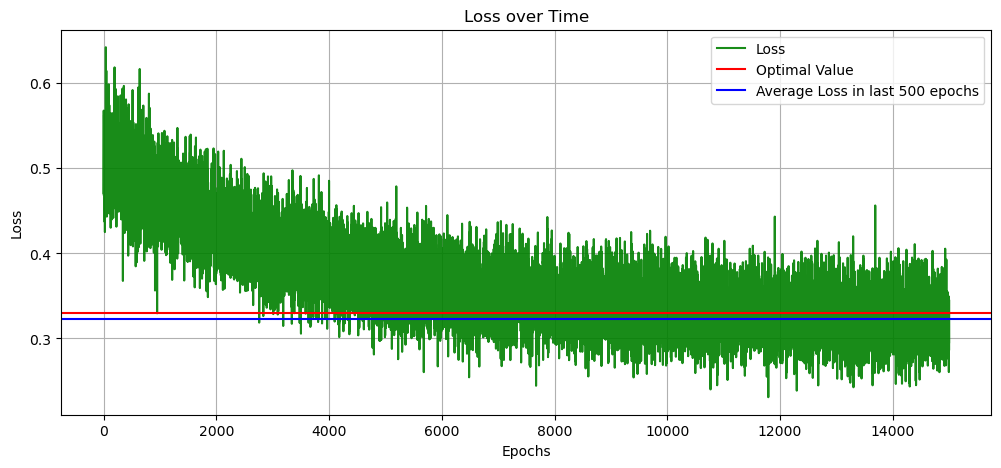

In [13]:
plt.figure(figsize=(12,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Time')

plt.grid()
plt.plot(np.arange(len(loss_arr)), loss_arr, alpha=0.9, color='green', label='Loss')
plt.axhline(0.33, color='red', label='Optimal Value')
plt.axhline(np.mean(loss_arr[-500:]), color='blue', label='Average Loss in last 500 epochs')
plt.legend()
print(np.mean(loss_arr[-500:]))
print(np.var(loss_arr[-500:]))

# P = 1

# $N_p = 1$

In [ ]:
# Initialize neural networks
sigma_net = SigmaNet()
u2_net = UFunctionNet()

# Learning rates
learning_rate_sigma_initial = 1e-4
learning_rate_u2_initial = 1e-4
decay_rate = 0.80
steps = 1000

num_epochs = 15000
batch_size = 64
num_paths = 1
loss_arr = []


# Momentum Coefficient
beta = 0.90  # Momentum coefficient

# Initialize velocity variables for sigma_net and u2_net parameters
v_sigma = [torch.zeros_like(p) for p in sigma_net.parameters()]
v_u2 = [torch.zeros_like(p) for p in u2_net.parameters()]

# Training loop with Momentum in Stochastic Extragradient Method
for epoch in range(num_epochs):
    learning_rate_sigma = learning_rate_sigma_initial * decay_rate ** np.floor(epoch / steps)
    learning_rate_u2 = learning_rate_u2_initial * decay_rate ** np.floor(epoch / steps)
    
    # Sample X and Y
    X_np = mu1(batch_size)
    Y_np = mu2(batch_size)
    X = torch.from_numpy(X_np).float()
    Y = torch.from_numpy(Y_np).float()

    # Step 1: Compute gradients at current parameters (sigma_k, u_k)
    # Zero gradients
    for p in sigma_net.parameters():
        if p.grad is not None:
            p.grad.zero_()
    for p in u2_net.parameters():
        if p.grad is not None:
            p.grad.zero_()

    # Compute loss at current parameters
    loss_current, inner_mean_current, u2Y_mean_current, cost_mean_current = compute_loss(
        X, Y, sigma_net, u2_net, num_paths=num_paths
    )

    # Compute gradients
    loss_current.backward()

    # Save copies of the current parameters and gradients
    sigma_params_backup = [p.data.clone() for p in sigma_net.parameters()]
    u2_params_backup = [p.data.clone() for p in u2_net.parameters()]

    sigma_grads_current = [p.grad.data.clone() for p in sigma_net.parameters()]
    u2_grads_current = [p.grad.data.clone() for p in u2_net.parameters()]

    # Step 2: Extrapolation step to intermediate parameters (without momentum)
    with torch.no_grad():
        # Update parameters for sigma_net (minimization)
        for p, g in zip(sigma_net.parameters(), sigma_grads_current):
            p.add_(-learning_rate_sigma * g)  # p = p - learning_rate * g (no momentum)

        # Update parameters for u2_net (maximization)
        for p, g in zip(u2_net.parameters(), u2_grads_current):
            p.add_(learning_rate_u2 * g)  # p = p + learning_rate * g (no momentum)

    # Step 3: Compute gradients at intermediate parameters
    # Zero gradients
    for p in sigma_net.parameters():
        p.grad.zero_()
    for p in u2_net.parameters():
        p.grad.zero_()

    # Re-sample data for intermediate step (or use the same data)
    X_np_intermediate = mu1(batch_size)
    Y_np_intermediate = mu2(batch_size)
    X_intermediate = torch.from_numpy(X_np_intermediate).float()
    Y_intermediate = torch.from_numpy(Y_np_intermediate).float()

    # Compute loss at intermediate parameters
    loss_intermediate, inner_mean_intermediate, u2Y_mean_intermediate, cost_mean_intermediate = compute_loss(
        X_intermediate, Y_intermediate, sigma_net, u2_net, num_paths=num_paths
    )

    # Backward to compute gradients at intermediate parameters
    loss_intermediate.backward()

    # Store gradients at intermediate point
    sigma_grads_intermediate = [p.grad.data.clone() for p in sigma_net.parameters()]
    u2_grads_intermediate = [p.grad.data.clone() for p in u2_net.parameters()]

    # Step 4: Restore original parameters
    with torch.no_grad():
        for p, p_backup in zip(sigma_net.parameters(), sigma_params_backup):
            p.data.copy_(p_backup)
        for p, p_backup in zip(u2_net.parameters(), u2_params_backup):
            p.data.copy_(p_backup)

    # Step 5: Final update using gradients at intermediate point with momentum
    with torch.no_grad():
        # Update velocities and parameters for sigma_net (minimization)
        for p, g, v in zip(sigma_net.parameters(), sigma_grads_intermediate, v_sigma):
            v.mul_(beta).add_((1 - beta), -learning_rate_sigma * g)  # v = beta * v - learning_rate * g
            p.add_(v)  # p = p + v

        # Update velocities and parameters for u2_net (maximization)
        for p, g, v in zip(u2_net.parameters(), u2_grads_intermediate, v_u2):
            v.mul_(beta).add_((1 - beta), learning_rate_u2 * g)  # v = beta * v + learning_rate * g
            p.add_(v)  # p = p + v

    # Zero gradients for next iteration
    for p in sigma_net.parameters():
        p.grad.zero_()
    for p in u2_net.parameters():
        p.grad.zero_()

    loss_arr.append(loss_current.item())
    # Print loss and other metrics every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_current.item():.4f}, "
              f"Inner Mean: {inner_mean_current.item():.4f}, U2_Y Mean: {u2Y_mean_current.item():.4f}, "
              f"Cost Mean: {cost_mean_current.item():.4f}")

Epoch 0, Loss: 0.6944, Inner Mean: 0.5290, U2_Y Mean: 0.1654, Cost Mean: 0.7199
Epoch 500, Loss: 0.6640, Inner Mean: 0.4813, U2_Y Mean: 0.1827, Cost Mean: 0.6530
Epoch 1000, Loss: 0.6030, Inner Mean: 0.4372, U2_Y Mean: 0.1658, Cost Mean: 0.6020
Epoch 1500, Loss: 0.4910, Inner Mean: 0.3212, U2_Y Mean: 0.1698, Cost Mean: 0.4835
Epoch 2000, Loss: 0.5301, Inner Mean: 0.3447, U2_Y Mean: 0.1854, Cost Mean: 0.5132
Epoch 2500, Loss: 0.5316, Inner Mean: 0.3602, U2_Y Mean: 0.1714, Cost Mean: 0.5481
Epoch 3000, Loss: 0.4806, Inner Mean: 0.3073, U2_Y Mean: 0.1732, Cost Mean: 0.4672
Epoch 3500, Loss: 0.5124, Inner Mean: 0.3269, U2_Y Mean: 0.1855, Cost Mean: 0.4962
Epoch 4000, Loss: 0.4309, Inner Mean: 0.2602, U2_Y Mean: 0.1707, Cost Mean: 0.4191
Epoch 4500, Loss: 0.4479, Inner Mean: 0.2741, U2_Y Mean: 0.1738, Cost Mean: 0.4295
Epoch 5000, Loss: 0.4376, Inner Mean: 0.2596, U2_Y Mean: 0.1781, Cost Mean: 0.4280
Epoch 5500, Loss: 0.5050, Inner Mean: 0.3227, U2_Y Mean: 0.1823, Cost Mean: 0.4878
Epoch 60

0.33791405230760574
0.000978677047251436


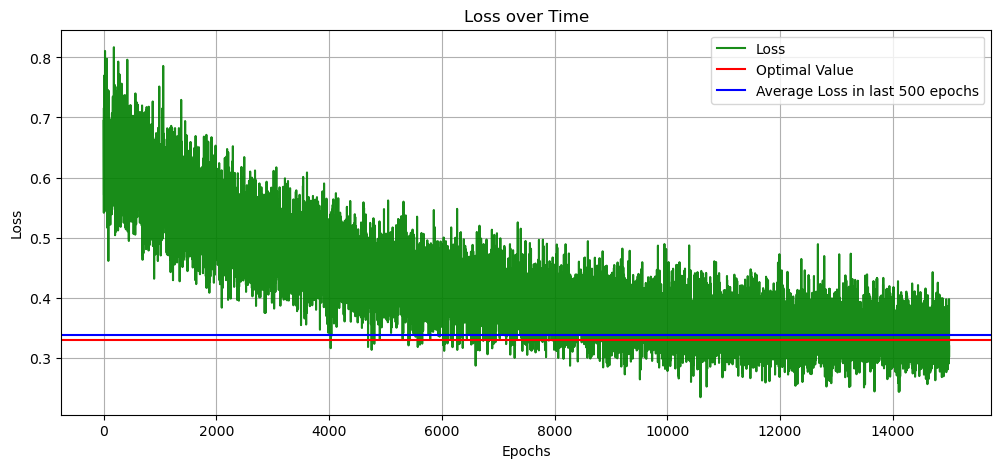

In [33]:
plt.figure(figsize=(12,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Time')

plt.grid()
plt.plot(np.arange(len(loss_arr)), loss_arr, alpha=0.9, color='green', label='Loss')
plt.axhline(0.33, color='red', label='Optimal Value')
plt.axhline(np.mean(loss_arr[-500:]), color='blue', label='Average Loss in last 500 epochs')
plt.legend()
print(np.mean(loss_arr[-500:]))
print(np.var(loss_arr[-500:]))

# 3D Case

## Same Neural Networks used

In [ ]:
# SigmaNet
class SigmaNet(nn.Module):
    def __init__(self, hidden_size=32):
        super(SigmaNet, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        
    def forward(self, s, S_s):
        x = torch.cat((s, S_s), dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        sigma_s = self.fc3(x)
        sigma_s = self.softplus(sigma_s)  # Ensure sigma_s > 0
        return sigma_s

# UFunctionNet
class UFunctionNet(nn.Module):
    def __init__(self, hidden_size=32):
        super(UFunctionNet, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()  # Use ReLU activation

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        u = self.relu(self.fc3(x))
        return u

## Marginal Distributions

In [ ]:
# Sampling functions
def mu1(batch_size):
    t = 1
    sigma = 0.25
    x = np.random.normal(loc=0.0, scale=1.0, size=batch_size)
    return np.exp(sigma * np.sqrt(t) * x - (sigma ** 2) * t * 0.5)

def mu2(batch_size):
    t = 2
    sigma = 0.25
    x = np.random.normal(loc=0.0, scale=1.0, size=batch_size)
    return np.exp(sigma * np.sqrt(t) * x - (sigma ** 2) * t * 0.5)
        
def mu3(batch_size):
    t = 3
    sigma = 0.25
    x = np.random.normal(loc=0.0, scale=1.0, size=batch_size)
    return np.exp(sigma * np.sqrt(t) * x - (sigma ** 2) * t * 0.5)

## Function to simulate X2 and X3, and compute Loss

In [ ]:
# Function to Simulate X_2
def simulate_S2_multiple(X, sigma_net, num_paths=2, num_steps=50):
    batch_size = X.size(0)
    dt = 1.0 / num_steps

    # Expand X to match the number of paths
    X_expanded = X.unsqueeze(1).repeat(1, num_paths)  # Shape: (batch_size, num_paths)
    S_s = X_expanded.clone()  # Shape: (batch_size, num_paths)

    # Initialize W_s (cumulative Brownian motion) to zero at t = 1
    W_s = torch.zeros_like(S_s)  # Shape: (batch_size, num_paths)

    for i in range(num_steps):
        s = torch.full((batch_size, num_paths), 1.0 + (i + 1) * dt).float()  # Corrected time step

        # Flatten inputs for sigma_net
        s_flat = s.reshape(-1, 1)     # Shape: (batch_size * num_paths, 1)
        W_s_flat = W_s.reshape(-1, 1) # Shape: (batch_size * num_paths, 1)

        # Compute sigma_s using (t, W_{t-1}) as inputs
        sigma_s = sigma_net(s_flat, W_s_flat)  # Output shape: (batch_size * num_paths, 1)
        sigma_s = sigma_s.reshape(batch_size, num_paths)

        # Brownian increments
        dB_s = torch.randn(batch_size, num_paths) * np.sqrt(dt)  # Shape: (batch_size, num_paths)

        # Update S_s
        S_s = S_s + sigma_s * dB_s  # Shape: (batch_size, num_paths)

        # Update W_s with the current Brownian increment
        W_s = W_s + dB_s  # W_s at time t

    # Return the final states S_2
    S_2 = S_s  # Shape: (batch_size, num_paths)
    return S_2

# Function to simulate X3
def simulate_S3_multiple(Y, sigma_net, num_paths=2, num_steps=50):
    batch_size = Y.size(0)
    dt = 1.0 / num_steps

    # Expand Y to match the number of paths
    Y_expanded = Y.unsqueeze(1).repeat(1, num_paths)  # Shape: (batch_size, num_paths)
    S_s = Y_expanded.clone()  # Shape: (batch_size, num_paths)

    # Initialize W_s (cumulative Brownian motion) to zero at t = 2
    W_s = torch.zeros_like(S_s)  # Shape: (batch_size, num_paths)

    for i in range(num_steps):
        s = torch.full((batch_size, num_paths), 2.0 + (i + 1) * dt).float()  # Corrected time step

        # Flatten inputs for sigma_net
        s_flat = s.reshape(-1, 1)     # Shape: (batch_size * num_paths, 1)
        W_s_flat = W_s.reshape(-1, 1) # Shape: (batch_size * num_paths, 1)

        # Compute sigma_s using (t, W_{t-1}) as inputs
        sigma_s = sigma_net(s_flat, W_s_flat)  # Output shape: (batch_size * num_paths, 1)
        sigma_s = sigma_s.reshape(batch_size, num_paths)

        # Brownian increments
        dB_s = torch.randn(batch_size, num_paths) * np.sqrt(dt)  # Shape: (batch_size, num_paths)

        # Update S_s
        S_s = S_s + sigma_s * dB_s  # Shape: (batch_size, num_paths)

        # Update W_s with the current Brownian increment
        W_s = W_s + dB_s  # W_s at time t

    # Return the final states S_3
    S_3 = S_s  # Shape: (batch_size, num_paths)
    return S_3

def cost_function(S1, S2, S3):
    return torch.clamp(S3 - 0.5 * (S1 + S2), min=0)

def compute_loss(S1, S2, S3, Sigma1, Sigma2, U2, U3, num_paths):
    S1 = torch.from_numpy(S1).float()  # Shape: (batch_size,)
    S2 = torch.from_numpy(S2).float()
    S3 = torch.from_numpy(S3).float()

    batch_size = S1.size(0)

    # Simulate X2 and X3
    X2 = simulate_S2_multiple(S1, Sigma1, num_paths=num_paths)  # Shape: (batch_size, num_paths)
    X2_flatten = X2.reshape(-1, 1)  # Shape: (batch_size * num_paths, 1)

    X3 = simulate_S3_multiple(X2_flatten.squeeze(), Sigma2, num_paths=num_paths)  # Shape: (batch_size * num_paths, num_paths)
    X3_flatten = X3.reshape(-1, 1)  # Shape: (batch_size * num_paths * num_paths, 1)

    # Expand S1 to match dimensions of X3
    S1_Expanded = S1.view(batch_size, 1, 1).expand(-1, num_paths, num_paths)
    # Shape: (batch_size, num_paths, num_paths)

    # Expand X2 to match dimensions of X3
    X2_Expanded = X2.view(batch_size, num_paths, 1).expand(-1, -1, num_paths)
    # Shape: (batch_size, num_paths, num_paths)

    # Reshape X3 to (batch_size, num_paths, num_paths)
    X3_reshaped = X3.view(batch_size, num_paths, num_paths)

    # Compute cost
    cost = cost_function(S1_Expanded, X2_Expanded, X3_reshaped)  # Shape: (batch_size, num_paths, num_paths)

    # Compute u_i(X_i), i = 2, 3
    u2_X2 = U2(X2_flatten)  # Shape: (batch_size * num_paths, 1)
    u2_X2_reshaped = u2_X2.view(batch_size, num_paths, 1)  # Shape: (batch_size, num_paths, 1)
    u2_X2_expanded = u2_X2_reshaped.expand(-1, -1, num_paths)  # Shape: (batch_size, num_paths, num_paths)

    u3_X3 = U3(X3_flatten)  # Shape: (batch_size * num_paths * num_paths, 1)
    u3_X3_reshaped = u3_X3.view(batch_size, num_paths, num_paths)  # Shape: (batch_size, num_paths, num_paths)

    # Compute u_loss
    u_loss = u2_X2_expanded + u3_X3_reshaped  # Shape: (batch_size, num_paths, num_paths)

    # Compute L1
    L1 = cost.mean() - u_loss.mean()

    # Compute u_i(S_i), i = 2 ,3
    u2_S2 = U2(S2.view(-1, 1))
    u3_S3 = U3(S3.view(-1, 1))

    L2 = u2_S2.mean() + u3_S3.mean()

    L = L1 + L2
    return L, L1, L2

## Model Training

In [ ]:
# Initialize Neural Networks
Sigma1 = SigmaNet()
Sigma2 = SigmaNet()
U2 = UFunctionNet()
U3 = UFunctionNet()

# Learning rates
lr_Sigma1_init = 1e-4
lr_Sigma2_init = 1e-4
lr_U2_init = 1e-4
lr_U3_init = 1e-4

decay_rate = 0.8
steps = 1000

# Training Params
batch_size = 64  
num_paths = 2     
max_iter = 15000
beta = 0.9

# Initialize velocity variables
v_sigma1 = [torch.zeros_like(p) for p in Sigma1.parameters()]
v_sigma2 = [torch.zeros_like(p) for p in Sigma2.parameters()]
v_u2 = [torch.zeros_like(p) for p in U2.parameters()]
v_u3 = [torch.zeros_like(p) for p in U3.parameters()]

loss_arr = []
for epoch in range(max_iter):
    
    lr_Sigma1 = lr_Sigma1_init * decay_rate ** np.floor(epoch / steps)
    lr_Sigma2 = lr_Sigma2_init * decay_rate ** np.floor(epoch / steps)
    lr_U2 = lr_U2_init * decay_rate ** np.floor(epoch / steps)
    lr_U3 = lr_U3_init * decay_rate ** np.floor(epoch / steps)

    # Sample S1, S2, S3
    S1 = mu1(batch_size)
    S2 = mu2(batch_size)
    S3 = mu3(batch_size)

    # Zero gradients
    for net in [Sigma1, Sigma2, U2, U3]:
        net.zero_grad()
    
    # Compute Starting Loss
    L, L1, L2 = compute_loss(S1, S2, S3, Sigma1, Sigma2, U2, U3, num_paths)

    # Compute gradients
    L.backward()

    # Save copies of the current parameters and gradients
    sigma1_params_cache = [p.data.clone() for p in Sigma1.parameters()]
    sigma2_params_cache = [p.data.clone() for p in Sigma2.parameters()]
    u2_params_cache = [p.data.clone() for p in U2.parameters()]
    u3_params_cache = [p.data.clone() for p in U3.parameters()]
    sigma1_grads_current = [p.grad.data.clone() for p in Sigma1.parameters()]
    sigma2_grads_current = [p.grad.data.clone() for p in Sigma2.parameters()]
    u2_grads_current = [p.grad.data.clone() for p in U2.parameters()]
    u3_grads_current = [p.grad.data.clone() for p in U3.parameters()]

    # Extrapolation step to intermediate parameters (without momentum)
    with torch.no_grad():
        # Update parameters for Sigma1 (minimization)
        for p, g in zip(Sigma1.parameters(), sigma1_grads_current):
            p.add_(-lr_Sigma1 * g)  # Gradient descent (no momentum)
        
        # Update parameters for Sigma2 (minimization)
        for p, g in zip(Sigma2.parameters(), sigma2_grads_current):
            p.add_(-lr_Sigma2 * g)  # Gradient descent (no momentum)

        # Update parameters for U2 (maximization)
        for p, g in zip(U2.parameters(), u2_grads_current):
            p.add_(lr_U2 * g)  # Gradient ascent (no momentum)
        
        # Update parameters for U3 (maximization)
        for p, g in zip(U3.parameters(), u3_grads_current):
            p.add_(lr_U3 * g)  # Gradient ascent (no momentum)
    
    # Zero gradients before computing intermediate gradients
    for net in [Sigma1, Sigma2, U2, U3]:
        net.zero_grad()

    # Compute loss at intermediate parameters
    L_intermediate, L1_intermediate, L2_intermediate = compute_loss(
        S1, S2, S3, Sigma1, Sigma2, U2, U3, num_paths=num_paths
    )

    # Backward to compute gradients at intermediate parameters
    L_intermediate.backward()

    # Store gradients at intermediate point
    sigma1_grads_intermediate = [p.grad.data.clone() for p in Sigma1.parameters()]
    sigma2_grads_intermediate = [p.grad.data.clone() for p in Sigma2.parameters()]
    u2_grads_intermediate = [p.grad.data.clone() for p in U2.parameters()]
    u3_grads_intermediate = [p.grad.data.clone() for p in U3.parameters()]

    # Restore original parameters
    with torch.no_grad():
        for p, p_backup in zip(Sigma1.parameters(), sigma1_params_cache):
            p.data.copy_(p_backup)
        for p, p_backup in zip(Sigma2.parameters(), sigma2_params_cache):
            p.data.copy_(p_backup)
        for p, p_backup in zip(U2.parameters(), u2_params_cache):
            p.data.copy_(p_backup)
        for p, p_backup in zip(U3.parameters(), u3_params_cache):
            p.data.copy_(p_backup)
    
    # Update parameters using gradients at intermediate point WITH momentum
    with torch.no_grad():
        # Update velocities and parameters for Sigma1 (minimization)
        for p, g, v in zip(Sigma1.parameters(), sigma1_grads_intermediate, v_sigma1):
            v.mul_(beta).add_(-lr_Sigma1 * g)  # v = beta * v - lr * g
            p.add_(v)  # p = p + v
        
        # Update velocities and parameters for Sigma2 (minimization)
        for p, g, v in zip(Sigma2.parameters(), sigma2_grads_intermediate, v_sigma2):
            v.mul_(beta).add_(-lr_Sigma2 * g)  # v = beta * v - lr * g
            p.add_(v)  # p = p + v

        # Update velocities and parameters for U2 (maximization)
        for p, g, v in zip(U2.parameters(), u2_grads_intermediate, v_u2):
            v.mul_(beta).add_(lr_U2 * g)  # v = beta * v + lr * g
            p.add_(v)  # p = p + v
        
        # Update velocities and parameters for U3 (maximization)
        for p, g, v in zip(U3.parameters(), u3_grads_intermediate, v_u3):
            v.mul_(beta).add_(lr_U3 * g)  # v = beta * v + lr * g
            p.add_(v)  # p = p + v
    
    # Zero gradients for next iteration
    for net in [Sigma1, Sigma2, U2, U3]:
        net.zero_grad()

    loss_arr.append(L.item())
    # Print loss and other metrics every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {L.item():.4f}, "
              f"L1 (Cost - U Loss): {L1.item():.4f}, L2 (U_S Mean): {L2.item():.4f}"
              )

Epoch 0, Loss: 0.2874, L1 (Cost - U Loss): -0.0730, L2 (U_S Mean): 0.3604
Epoch 500, Loss: 0.3181, L1 (Cost - U Loss): -0.0517, L2 (U_S Mean): 0.3698
Epoch 1000, Loss: 0.2094, L1 (Cost - U Loss): -0.1983, L2 (U_S Mean): 0.4077
Epoch 1500, Loss: 0.1935, L1 (Cost - U Loss): -0.2405, L2 (U_S Mean): 0.4340
Epoch 2000, Loss: 0.1757, L1 (Cost - U Loss): -0.2638, L2 (U_S Mean): 0.4396
Epoch 2500, Loss: 0.1589, L1 (Cost - U Loss): -0.2524, L2 (U_S Mean): 0.4112
Epoch 3000, Loss: 0.1139, L1 (Cost - U Loss): -0.2695, L2 (U_S Mean): 0.3834
Epoch 3500, Loss: 0.1124, L1 (Cost - U Loss): -0.2372, L2 (U_S Mean): 0.3497
Epoch 4000, Loss: 0.0907, L1 (Cost - U Loss): -0.2152, L2 (U_S Mean): 0.3059
Epoch 4500, Loss: 0.1133, L1 (Cost - U Loss): -0.1796, L2 (U_S Mean): 0.2929
Epoch 5000, Loss: 0.0595, L1 (Cost - U Loss): -0.2118, L2 (U_S Mean): 0.2713
Epoch 5500, Loss: 0.0963, L1 (Cost - U Loss): -0.1833, L2 (U_S Mean): 0.2796
Epoch 6000, Loss: 0.0402, L1 (Cost - U Loss): -0.2075, L2 (U_S Mean): 0.2477
Epo

0.06289326509833336
0.0004398800259612089


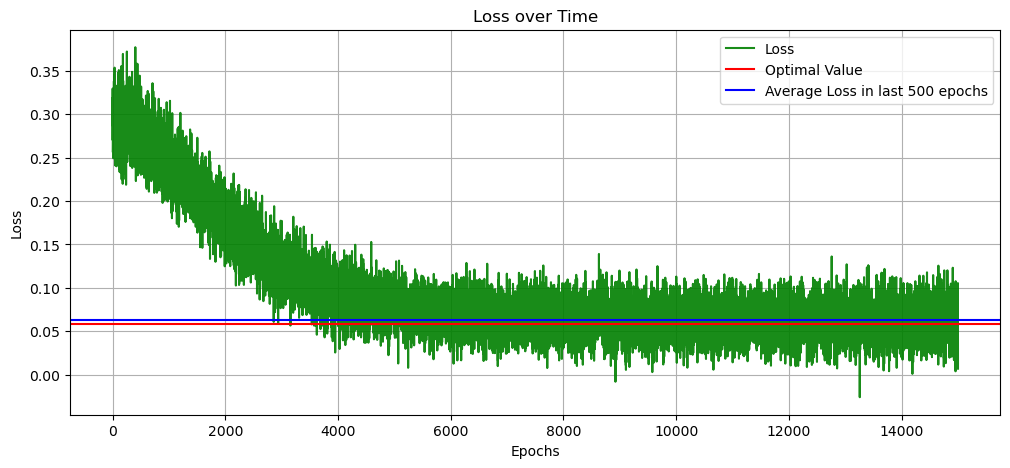

In [17]:
plt.figure(figsize=(12,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Time')

plt.grid()
plt.plot(np.arange(len(loss_arr)), loss_arr, alpha=0.9, color='green', label='Loss')
plt.axhline(0.059, color='red', label='Optimal Value')
plt.axhline(np.mean(loss_arr[-500:]), color='blue', label='Average Loss in last 500 epochs')
plt.legend()
print(np.mean(loss_arr[-500:]))
print(np.var(loss_arr[-500:]))